In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class Fractal2D:
    
    """
    Fractal class for Project: Newton Method Fractals in the course NUMA01
    """
    
    def __init__(self, f, deriv=None):
        """
        Initialization method which assigns a function, a jacobian and an empty list of zeros to the instance.
        :param f: Function f which zeroes are of interest.
        :(Optional) param deriv: Jacobian of the function f. Either exact jacobian (must be prescribed manually), but if none then finite difference jacobian is used.
        """
        self.f = f
        if deriv:
            self.deriv = deriv
        else:
            self.deriv = self.jacobian
        self.zeros=[]
    
    def newtons_method(self, x, tol=1e-6, maxiter=20):
        """
        Function that finds zero by using Newtons method:
        0 = f(x0) + J(x0)(x1-x0) ->  x1 = x0 + J(x0) ** -1 @ -f(x0)
        :param x: Start point.
        :(Optional) param tol: Tolerance for zero, i.e if sqrt(||f(x_i)||_2) < tol -> x_i is a zero.
        :(Optional) param maxiter: Max iteration of newtons method.
        :return: Point where function is zero and number of iterations. None and None if zero is not found.
        """
        for i in range(maxiter):
            dx = np.linalg.solve(self.deriv(x), -self.f(x))
            x = x + dx
            if np.linalg.norm(self.f(x)) < tol:
                return x, i
            
        return None, None

    def simplified_newtons_method(self, x, tol=1e-6, maxiter=20):
        """
        Function that finds zero by using simplified Newtons method:
        0 = f(x0) + J(x0)(x1-x0) ->  x1 = x0 + J(x0) ** -1 @ -f(x0)
        But jacobian is only calculated at first point.
        :param x: Start point.
        :(Optional) param tol: Tolerance for zero, i.e if sqrt(||f(x_i)||_2) < tol -> x_i is a zero.
        :(Optional) param maxiter: Max iteration of newtons method.
        :return: Point where function is zero and number of iterations. None and None if zero is not found.
        """
        deriv = self.deriv(x)
        for i in range(maxiter):
            dx = np.linalg.solve(deriv, -self.f(x))
            x = x + dx
            if np.linalg.norm(self.f(x)) < tol:
                return x, i
            
        return None, None
    
    def find_zero(self, init_guess, tol=1e-6, min_dist=1e-3, simplified=False):
        """
        Function of finding zeros and then saving them, if not found return -1 
        :param init_guess: intial value of guess, expected type(np.array)
        :(optional) param tol: tolerance, expected type(float)
        :(optional) param min_dist: minimum distance between zeros, expected type(float)
        :(optional) param simplified: use of simplifed method, expected type(boolean)
        :return: index of zero in list
        """
        if simplified:
            x, i = self.simplified_newtons_method(init_guess, tol)
        else:
            x, i = self.newtons_method(init_guess, tol)
        if x is None:
            return None, None
        for idx, zeros in enumerate(self.zeros):
            if np.linalg.norm(x - zeros) < min_dist:
                return idx, i
        self.zeros.append(x)
        return len(self.zeros) - 1, i 
                
        
    def get_A(self, mesh, simplified=False): 
        """
        Building of the A matrix containing the index of the zero to which newton's algorithm converged from the point p_ij
        :param mesh: mesh represented as a tuple that sets up grid in the set G = [ a, b] x [ c, d], expected type(tuple(np.array))
        :(optional) param simplified: use of simplifed method, expected type(boolean)
        :return A: matrix of, expected type(np.array)
        """
        X, Y = mesh
        N, _= X.shape
        A = np.zeros((N, N))
        Ai = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                A[i, j], Ai[i, j] = self.find_zero(np.array([X[i, j],Y[i, j]]), simplified=simplified)
                
        self.zeros = []
        return A, Ai
                                        
    def plot(self, N, a, b, c, d, simplified=False, disp_iter=False, save_as=''):
        """
        Makes a colorplot over the index number of found zero when using newtons method starting at point (X{i, j}, Y{i, j}).
        :param N: Number of point in one dimension to be used for mesh. N -> N**2 mesh points, Expected type (int).
        :param a: left bound of interval in first dimension, expected types (int, float)
        :param b: right bound of interval in first dimension, expected types (int, float)
        :param c: left bound of interval in second dimension, expected types (int, float)
        :param d: right bound of interval in second dimension, expected types (int, float)
        :(Optional) param simplified: Uses simplified newton if True, else uses pure newton method.
        :(Optional) param disp_iter: Plots additional plot which showcases the number of iterations
        :(Optional) param simplified:
        """
        x = np.linspace(a, b, N)
        y = np.linspace(c, d, N)
        X,Y = np.meshgrid(x, y)
        A, Ai = self.get_A((X, Y), simplified=simplified)
        if disp_iter:
            fig, ax = plt.subplots(2, 1,figsize=(10,6))
            colorplot1 = ax[0].pcolor(X, Y, A)
            colorplot2 = ax[1].pcolor(X, Y, Ai)
            
            ax[0].set_xlabel('x')
            ax[0].set_ylabel('y')
            ax[0].set_title('Zeros (None if not converged, displayed as white)')
            
            ax[1].set_xlabel('x')
            ax[1].set_ylabel('y')
            ax[1].set_title('Iterations to convergence (None if not converged, displayed as white)')
            
            fig.colorbar(colorplot1, ax=ax[0])
            fig.colorbar(colorplot2, ax=ax[1])
            plt.tight_layout()
        else:
            fig, ax = plt.subplots(figsize=(10,6))
            colorplot1 = ax.pcolor(X, Y, A)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title('Zeros')
            fig.colorbar(colorplot1,ax=ax)
            
        if save_as:
            plt.savefig(save_as + '.png')
            
        plt.show()
    
    def jacobian(self, x, step_size=1e-8):
        """
        Calculates jacobian of vector-valued function at a point x by using finite differences.
        :param x: Evalueation point of jacobian, expected types (numpy array, list).
        :(Optional) param step_size: Step size for finite difference derivative, expected types (int, float, etc.).
        :return jac: Jacobian matrix of vector-valued function, (Numpy array).
        """
        dims = len(x)
        fx = self.f(x)
        jac = np.zeros((dims, dims))
        for dim in range(dims):
            x[dim] += step_size
            jac[:, dim] = (self.f(x) - fx)/step_size
            x[dim] -= step_size

        return jac

In [3]:
# Test functions
def f1(x):
    return np.array([x[0]**3 - 3*x[0]*(x[1]**2) - 1, 3*(x[0]**2)*x[1] - x[1]**3])

def f2(x):
    return np.array([x[0]**3 - 3*x[0]*(x[1]**2) -2*x[0] - 2, 3*(x[0]**2)*x[1] - x[1]**3 - 2*x[1]])

def f3(x):
    return np.array([x[0]**8 - 28 * (x[0]**6)*(x[1]**2) + 70 * (x[0]**4)*(x[1]**4) + 15 * (x[0] ** 4) \
                    - 28 * (x[0] ** 2) * (x[1] ** 6) - 90 * (x[0] ** 2) * (x[1] ** 2) + (x[1] ** 8) + 15 * (x[1] ** 4) - 16,
                    8 * (x[0] ** 7) * x[1] - 56 * (x[0] ** 5) * (x[1] ** 3) + 56 * (x[0] ** 3) * (x[1] ** 5) \
                    + 60 * (x[0] ** 3) * x[1] - 8 * x[0] * (x[1] ** 7) - 60 * x[0] * (x[1] ** 3)])

# Jacobians. j1 is jacobian for f1 etc.
def j1(x):
    return np.array([[3*(x[0]**2 - x[1]**2), -6*x[0]*x[1]], [6*x[0]*x[1], 3*(x[0]**2 - x[1]**2)]])

def j2(x):
    return np.array([[3*(x[0]**2 - x[1]**2) - 2, -6*x[0]*x[1]], [6*x[0]*x[1], 3*(x[0]**2 - x[1]**2) - 2]])

def j3(x):
    x, y = x[0], x[1]
    
    df1dx = 4 * (2 * (x ** 7) - 42 * (x ** 5) * (y ** 2) + 5 * (x ** 3) * (3 + 14 * (y ** 4)) - x * (y ** 2) * (45 + 14 * (y ** 4)))
    df1dy = 4 * y * (-14 * (x ** 6) + 70 * (x ** 4) * (y ** 2) + (y ** 2) * (15 + 2 * (y ** 4)) - 3 * (x ** 2) * (15 + 14 * (y ** 4)))
    
    df2dx = 4 * y * (14 * (x ** 6) - 70 * (x ** 4) * (y ** 2) - (y ** 2) * (15 + 2 * (y ** 4)) + (x ** 2) * (45 + 42 * (y ** 4)))
    df2dy = 4 * (2 * (x ** 7) - 42 * (x ** 5) * (y ** 2) + 5 * (x ** 3) * (3 + 14 * (y ** 4)) - x * (y ** 2) * (45 + 14 * (y ** 4)))
    return np.array([[df1dx, df1dy], [df2dx, df2dy]])

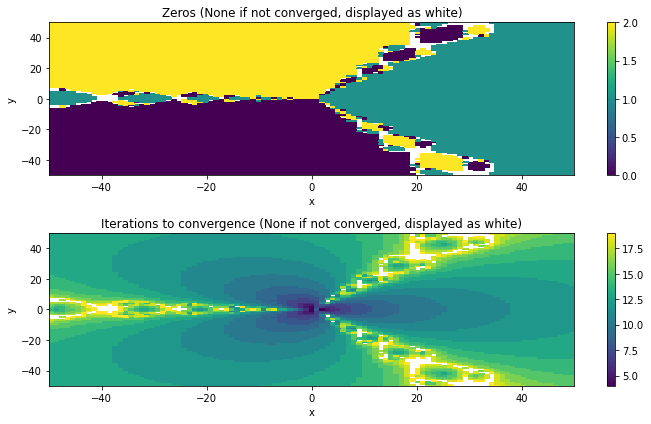

In [20]:
# Test env.
fractal = Fractal2D(f=f1, deriv=None)
# If save_as is empty string, then image is not saved, otherwise the image will be saved with the prescribed name.
fractal.plot(100, -5, 5, -5, 5, simplified=False, disp_iter=True, save_as='')